# 1.4. AirBnB Project Template

## Imports

In [1]:
# 
# MULTI LAYER PERCEPTRON - ARTIFICIAL NEURAL NETWORK - OPTIMIZED NETWORK
# Added custom metrics
# Putting all together for Production
#

import numpy as np # conda install numpy
import tensorflow as tf
import matplotlib.pyplot as plt # conda install matplotlib
import pandas as pd # conda install pandas
import warnings
import seaborn as sns # conda install seaborn - Python data visualization library based on matplotlib

warnings.filterwarnings('ignore')

print(tf.__version__)


2.15.0


## Load data and take a look at it - all data MUST be numeric

In [2]:
data = pd.read_csv('airbnb new york.csv').sample(frac=1) # returns a random sample of the whole dataframe (frac=1)
data.head()

#data.describe()


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
40789,31671911,Harry Potter Den,138456145,Neal,Brooklyn,Bushwick,40.69294,-73.90744,Private room,35,7,1,2019-04-27,0.41,1,36
7537,5647213,"Experience Brownstone Brooklyn: Comfy, Roomy 2BR",16482147,Margenett,Brooklyn,Bedford-Stuyvesant,40.68294,-73.92672,Entire home/apt,128,4,44,2019-06-20,1.98,1,88
1982,870119,Beautiful 2bdrm Bklyn duplex w/deck + backyard,355548,Jessica,Brooklyn,Clinton Hill,40.69208,-73.96525,Entire home/apt,185,4,8,2018-08-27,0.22,1,8
39303,30672646,5min walk to L train - Great Roommates! Fast W...,154981576,Bedly Bushwick,Brooklyn,Bushwick,40.70127,-73.91235,Private room,35,30,0,NaN,NaN,9,43
35586,28252662,Beautiful apartment in Elmhurst New York,129124146,KImberly,Queens,Elmhurst,40.73334,-73.87198,Shared room,65,1,4,2018-11-10,0.42,3,179


## Data preprocessing

In [3]:
features = data[['neighbourhood_group', 'room_type', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]
# display to lookout for categorical values
print('*** Columns\n', features.head())

# isna() return a boolean same-sized object indicating if the values are NA - None or numpy.NaN - and they get mapped to True values.
# the above features.isna().sum() shows that 'reviews_per_month' has several thousands od NA (missing) values.
print('\n*** Missing values\n', features.isna().sum()) 

features['reviews_per_month'] = features['reviews_per_month'].fillna(0) # fill NA missing values with 0s
print('\n*** Cleaned data\n', features.isna().sum()) # it shows data is cleaned

# get onehot encoding with pd.get_dummies()
onehot_neighborhood_group = pd.get_dummies(features['neighbourhood_group'])
onehot_room_type = pd.get_dummies(features['room_type'])

print('\n*** onehot encoded data\n')
print('\n', onehot_neighborhood_group)
print('\n', onehot_room_type)

features = features.drop(columns=['neighbourhood_group', 'room_type']) # drop columns with categorical data
features = pd.concat([features, onehot_neighborhood_group, onehot_room_type], axis=1) # concatenate dataframe with onehot encoded columns
print('\n*** Processed data\n', features.head()) # observe updated features 

targets = data['price'] # get the targets
train_size = int(0.7 * len(data)) # 70% od data will be used for training purposes

# gets 70% of rows with all columns for X_test, and the remaining 30% of rows with all columns 
X_train, X_test = features.values[:train_size, :], features.values[train_size:, :]
y_train, y_test = targets.values[:train_size], targets.values[train_size:]
print('\nTotal number of columns\n', len(X_test[0]))

*** Columns
       neighbourhood_group        room_type  minimum_nights  number_of_reviews  \
40789            Brooklyn     Private room               7                  1   
7537             Brooklyn  Entire home/apt               4                 44   
1982             Brooklyn  Entire home/apt               4                  8   
39303            Brooklyn     Private room              30                  0   
35586              Queens      Shared room               1                  4   

       reviews_per_month  calculated_host_listings_count  availability_365  
40789               0.41                               1                36  
7537                1.98                               1                88  
1982                0.22                               1                 8  
39303                NaN                               9                43  
35586               0.42                               3               179  

*** Missing values
 neighbourhood_gro

## Data visualization and analysis

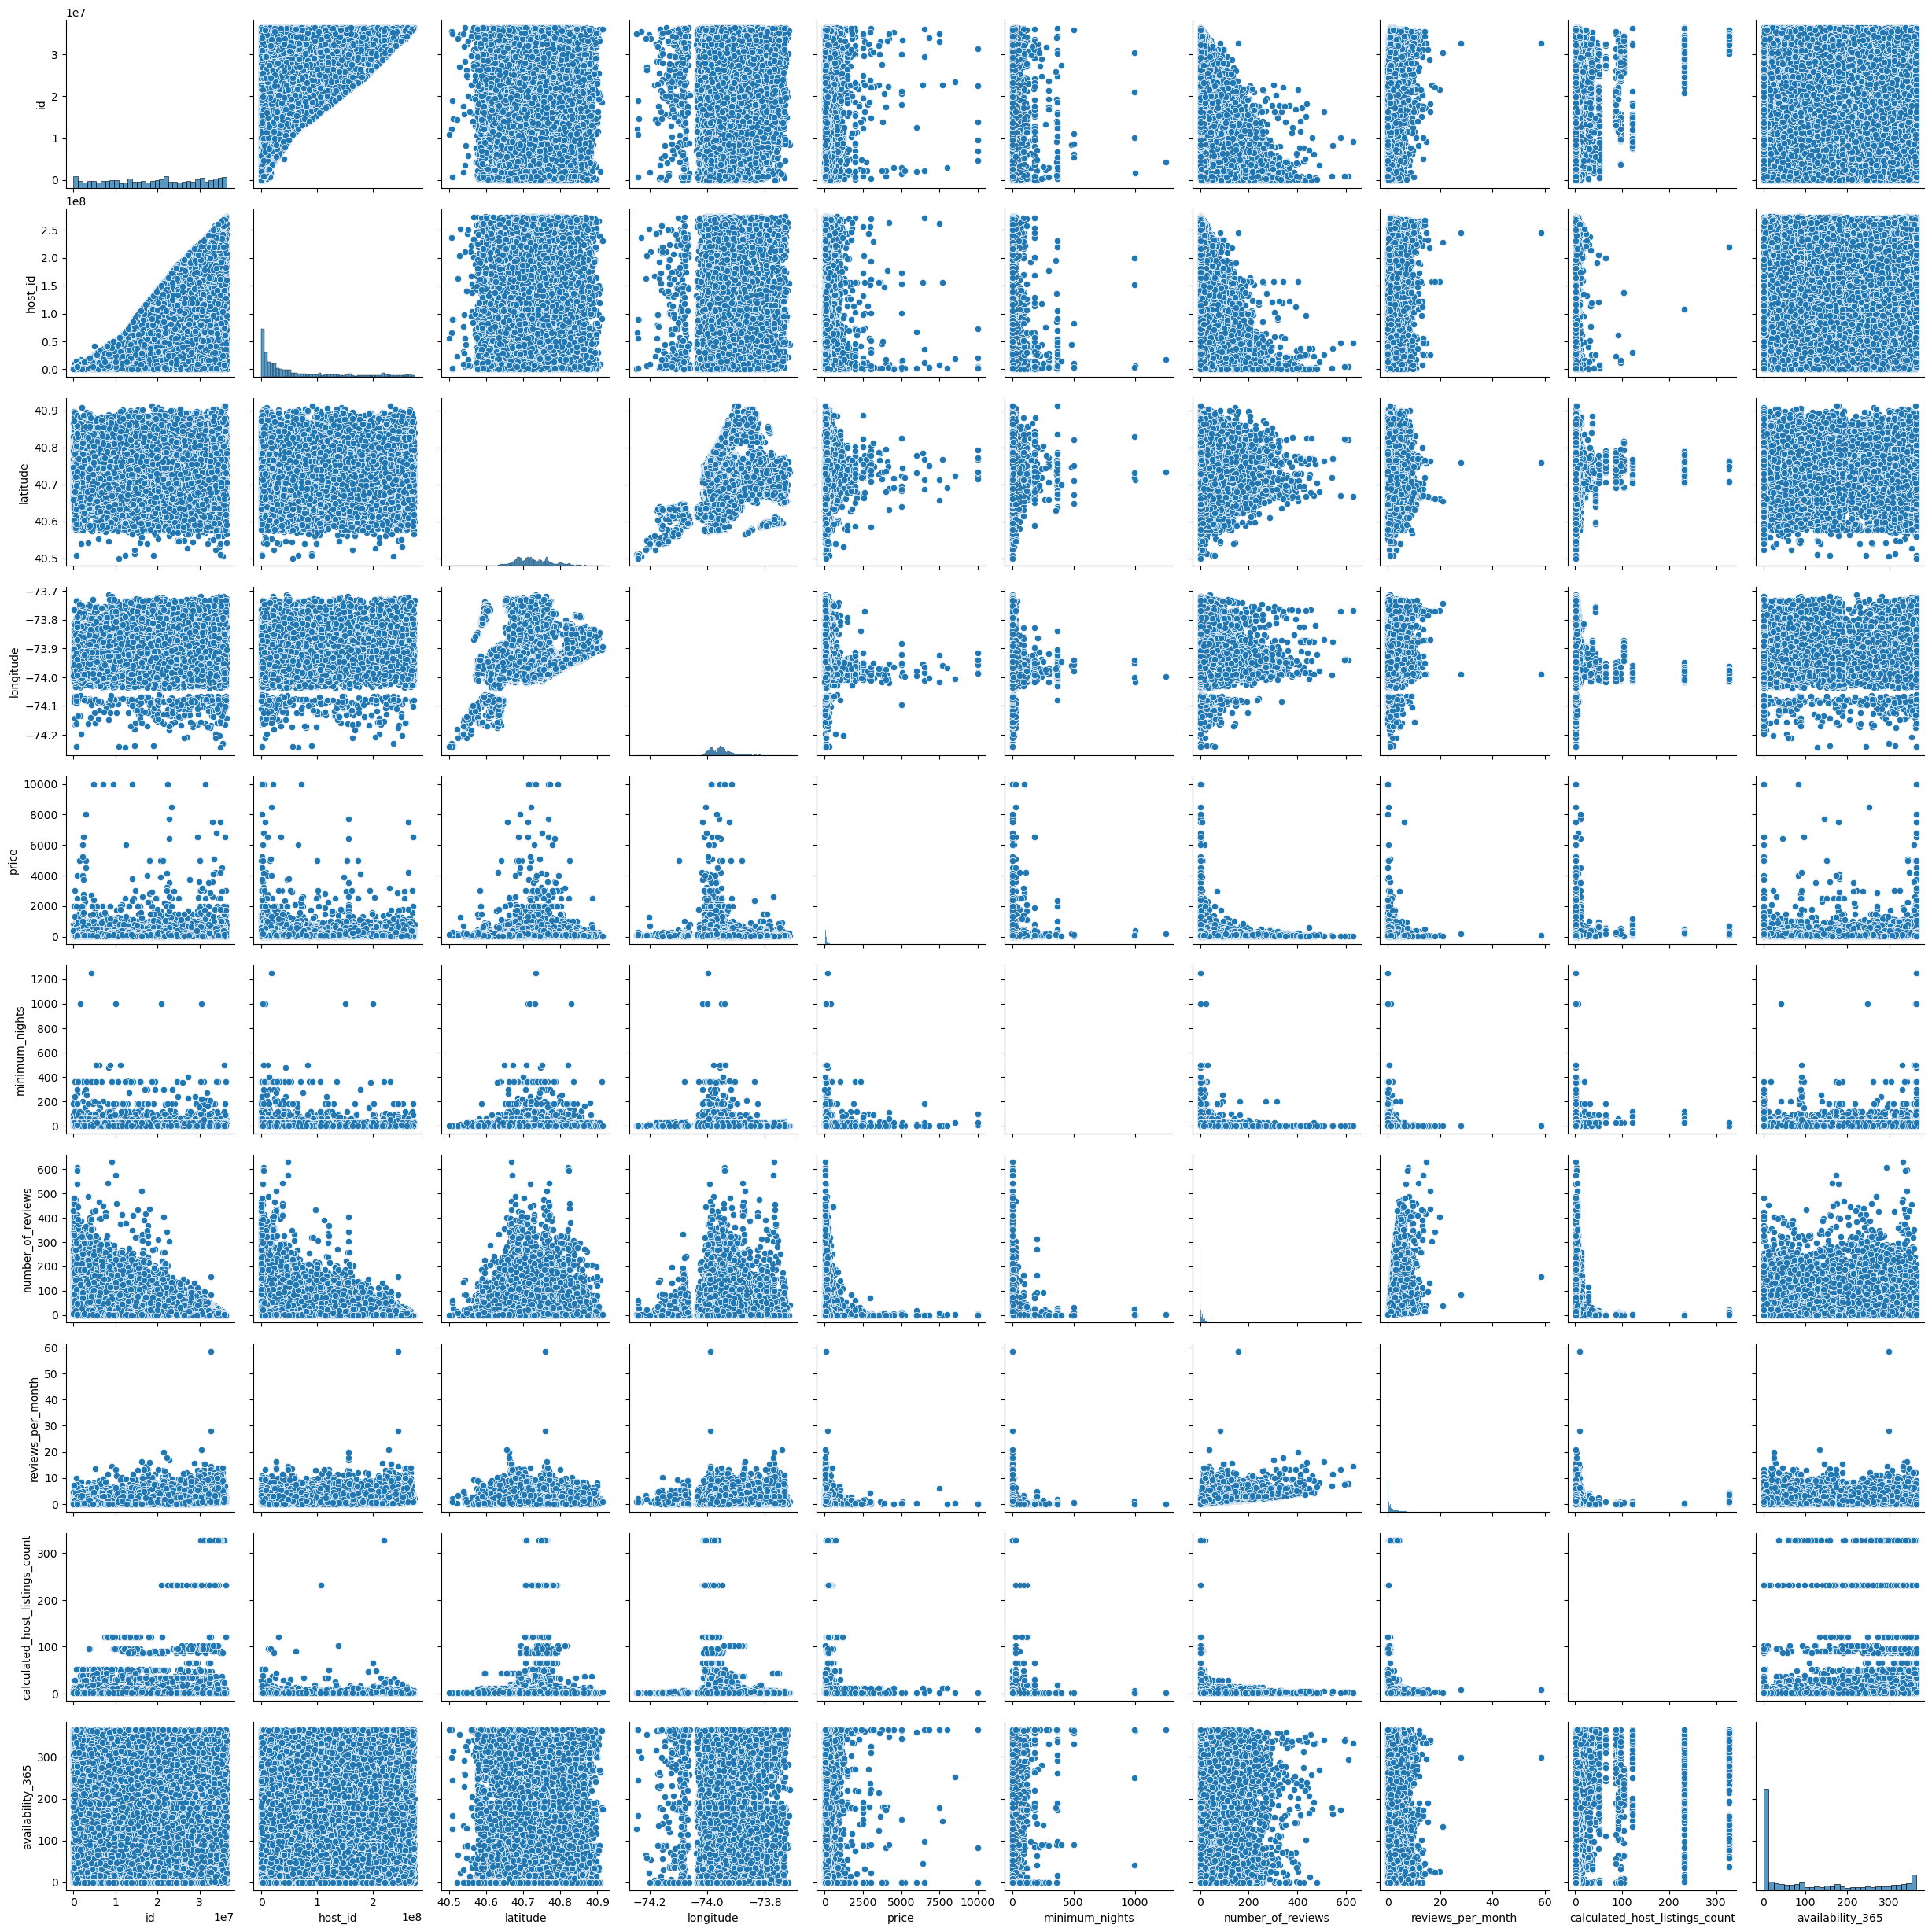

In [4]:
# pairplot() -  this function will create a grid of Axes such that each numeric variable in data will by shared
# across the y-axes across a single row and the x-axes across a single column. The diagonal plots are treated
# differently: a univariate distribution plot is drawn to show the marginal distribution of the data in each column
sns.pairplot(data)

<Axes: >

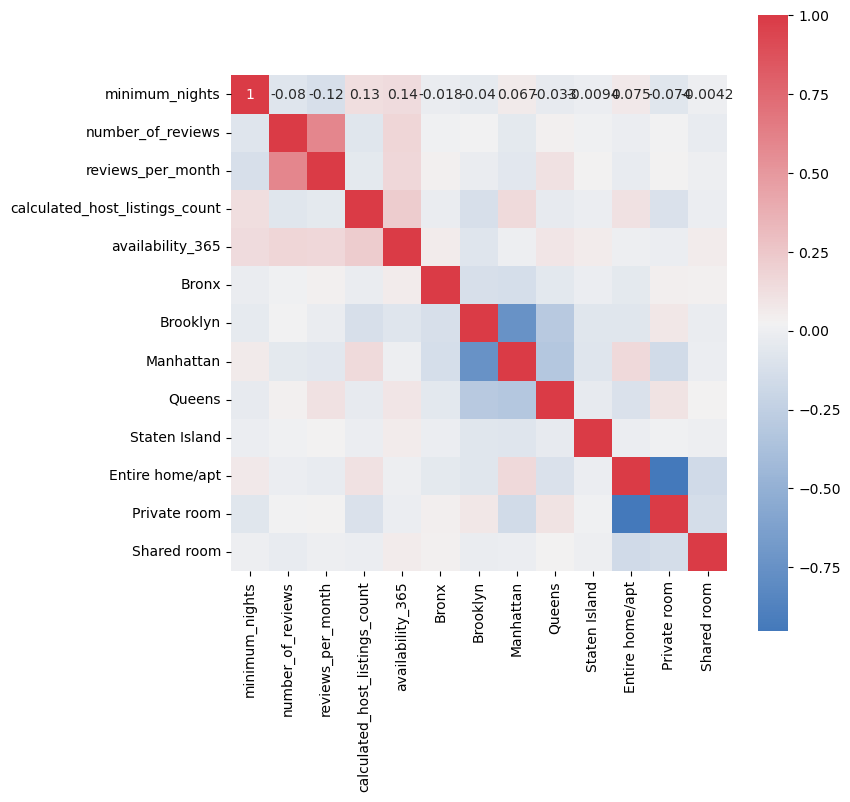

In [5]:
# corr = data.corr() # original data has categorical variables that produce errors
corr = features.corr() # corr() - Compute pairwise correlation of columns, excluding NA/null values.

cmap = sns.diverging_palette(250, 10, as_cmap=True) # Make a diverging palette between two HUSL colors.

# Create a new figure, or activate an existing figure.
# in this case the figure call with the figsize argument is used to define the size of the chart area.
plt.figure(figsize=(8, 8)) 

# heatmap() - Plot rectangular data as a color-encoded matrix.
sns.heatmap(corr, square=True, cmap=cmap, annot=True)

## Multi Layer Perceptron model (ANN - Artificial Neural Network)

In [6]:
# keras is part of tensorflow 2.x
# models.Sequential() indicates that every layer we add goes in sequential order, one after another
# A model grouping layers into an object with training/inference features.
# Sequential groups a linear stack of layers into a tf.keras.Model

# Dense(units) implements the operation: output = activation(dot(input, kernel) + bias) where 
# activation is the element-wise activation function passed as the activation argument, kernel is a weights
# matrix created by the layer, and bias is a bias vector created by the layer (only applicable if 
# use_bias is True). These are all attributes of Dense. units - Positive integer, dimensionality of the output space.
model = tf.keras.models.Sequential([
    
    # 1st layer - Dense() Just your regular densely-connected NN layer - 128 dimensions of output space
    # Activation function to use. If you don't specify anything, no activation is applied (ie. "linear" activation: a(x) = x).
    # relu - rectified linear unit activation function. With default values, this returns the standard ReLU 
    # activation: max(x, 0), the element-wise maximum of 0 and the input tensor.
    tf.keras.layers.Dense(128, activation='relu'), 
    
    # The Dropout layer randomly sets input units to ZERO with a frequency of rate at each step during training time, 
    # WHICH HELPS TO PREVENT OVERFITTING. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.
    tf.keras.layers.Dropout(0.2), # Dropout 20% of the input
    
    tf.keras.layers.Dense(1)    # 2nd layer - Dense() Just your regular densely-connected NN layer - 1 dimension of output space
])



In [7]:
# more metrics for better understanding
def R_squared(y_true, y_pred):
    # note use of .reduce_sum and .square tendorflow functions
    residual = tf.reduce_sum(tf.square(y_true - y_pred))
    # note use of .reduce_mean
    total = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1.0 - residual / total
    return r2

# the keras.optimizer is the equivalent of the train_step() function of the linear model
# Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
# USE THIS OPTION BY DEFAULT AND NOT CHANGE IT UNLESS YOU KNOW WHAT YOU ARE DOING
adam_optimizer = tf.keras.optimizers.Adam()
# 
loss_fn = tf.keras.losses.MAE   # uses the Mean Absolute Error 

# The compile() method: specifying a loss, metrics, and an optimizer
# To train a model with fit(), you need to specify a loss function, an optimizer, and optionally, some metrics to monitor.
model.compile(
    optimizer=adam_optimizer, 
    loss=loss_fn,
    #ADDED METRICS HERE
    metrics=[
        tf.keras.metrics.MAE,
        tf.keras.metrics.MSE,   # mean squared error
        R_squared, # result between -1 and +1, < 0 => useless, 0 and 1 => better close to 1
    ]
)


In [8]:
# reformats boolean data to float32
X_train = np.asarray(X_train, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32)

# fit() is for TRAINING THE MODEL with the given inputs (and corresponding training labels).
model.fit(X_train, y_train, epochs=10)


Epoch 1/10


1070/1070 [==============================] - 1s 889us/step - loss: 100.1736 - mean_absolute_error: 100.1736 - mean_squared_error: 66343.7734 - R_squared: -0.5498
Epoch 2/10
1070/1070 [==============================] - 1s 918us/step - loss: 70.9533 - mean_absolute_error: 70.9533 - mean_squared_error: 58628.8750 - R_squared: 0.1089
Epoch 3/10
1070/1070 [==============================] - 1s 873us/step - loss: 66.0473 - mean_absolute_error: 66.0473 - mean_squared_error: 56805.1250 - R_squared: 0.2178
Epoch 4/10
1070/1070 [==============================] - 1s 873us/step - loss: 65.2293 - mean_absolute_error: 65.2293 - mean_squared_error: 56574.8750 - R_squared: 0.2445
Epoch 5/10
1070/1070 [==============================] - 1s 905us/step - loss: 64.8160 - mean_absolute_error: 64.8160 - mean_squared_error: 56362.1836 - R_squared: 0.2477
Epoch 6/10
1070/1070 [==============================] - 1s 889us/step - loss: 64.6531 - mean_absolute_error: 64.6531 - mean_squared_error: 56324.

In [9]:
# Display the model's architecture
model.summary()

# evaluate() is for evaluating the already trained model using the validation (or test) data and the corresponding labels. 
# Returns the loss value and metrics values for the model.
X_test = np.asarray(X_test, dtype=np.float32)
y_test = np.asarray(y_test, dtype=np.float32)

# We EVALUATE THE MODEL on the test data via evaluate():
print('\nEvaluate the model on the test data')
model.evaluate(X_test, y_test)


# An entire model can be saved in three different file formats (the new .keras format and two legacy formats: SavedModel,
# and HDF5). Saving a model as path/to/model.keras automatically saves in the latest format.
# Saving a fully-functional model is very useful—you can load them in TensorFlow.js (Saved Model, HDF5) and then train and
# run them in web browsers, or convert them to run on mobile devices using TensorFlow Lite (Saved Model, HDF5)
# it saves de model,its architecture, and weights in 'this' notebook's folder
model.save('rbnb_model.h5')

# SIMULATE THE MODEL BEING USED ON A WEB API - load the saved model
loaded_model = tf.keras.models.load_model('rbnb_model.h5', custom_objects={"R_squared": R_squared})

print('\nCompare loaded_model vs model from above\n')
print(loaded_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1792      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1921 (7.50 KB)
Trainable params: 1921 (7.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Evaluate the model on the test data
459/459 [==============================] - 0s 743us/step - loss: 63.2958 - mean_absolute_error: 63.2958 - mean_squared_error: 48182.9453 - R_squared: 0.2708

Compare loaded_model vs model from above

Model: "sequential"
_______________________________

#### Making some predictions

In [10]:
print('\nPREDICTION - ORIGINAL MODULE\n')
print(model.predict(X_test[:2]))

print('\nPREDICTION - LOADED MODULE\n')
print(loaded_model(X_test[:2]))

print('\nACTUAL DATA\n')
print(y_test[:2])


PREDICTION - ORIGINAL MODULE

1/1 [==============================] - 0s 50ms/step
[[143.2725]
 [179.0155]]

PREDICTION - LOADED MODULE

tf.Tensor(
[[143.2725]
 [179.0155]], shape=(2, 1), dtype=float32)

ACTUAL DATA

[250. 220.]


## Conclusions

- Sometimes the dataset limits us with regards to results
    * Features not well correlated to the predicted values
- Data preprocessing and analysis is important - TensorFlow does not live in a bubble, it's a tool
    * It must work in conjunction with other tools
    * Seaborn, pandas, etc.
- TF 2 simplifies many things: no more placeholders, we do have eager execution, we do have .numpy(), no more sessions, Keras has a bigger role
- ANNs are very sensitive to hyperparameter choice
- Running on GPU can help, but it's not a must
- I CAN DO IT!